In [1]:
# * add cross validation
# Private: 0.8243
# Public: 0.83772

library(tidyverse)
library(xgboost)

set.seed(123)

train <- read.csv("/kaggle/input/santander-customer-satisfaction/train.csv")
test  <- read.csv("/kaggle/input/santander-customer-satisfaction/test.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [2]:
##### Removing IDs
train$ID <- NULL
test.id <- test$ID
test$ID <- NULL

##### Extracting TARGET
train.y <- train$TARGET
train$TARGET <- NULL

In [3]:
##### 0 count per line
count0 <- function(x) {
    return(sum(x == 0))
}
train$n0 <- apply(train, 1, FUN = count0)
test$n0 <- apply(test, 1, FUN = count0)

##### Removing constant features
cat("\n## Removing the constants features.\n")
for (f in names(train)) {
    if (length(unique(train[[f]])) == 1) {
        # cat(f, "is constant in train. We delete it.\n")
        train[[f]] <- NULL
        test[[f]] <- NULL
    }
}


## Removing the constants features.


In [4]:

##### Removing identical features
features_pair <- combn(names(train), 2, simplify = F)
toRemove <- c()
for (pair in features_pair) {
    f1 <- pair[1]
    f2 <- pair[2]
    
    if (!(f1 %in% toRemove) & !(f2 %in% toRemove)) {
        if (all(train[[f1]] == train[[f2]])) {
            # cat(f1, "and", f2, "are equals.\n")
            toRemove <- c(toRemove, f2)
        }
    }
}

feature.names <- setdiff(names(train), toRemove)

train <- train[, feature.names]
test <- test[, feature.names]

In [5]:
# Create additional features
# var38mc == 1 when var38 has the most common value and 0 otherwise
# logvar38 is log transformed feature when var38mc is 0, zero otherwise

train <- train %>%
    # This column mark the most common value
    mutate(var38mc = ifelse(near(var38, 117310.979016494), 1, 0), ) %>%
    
    # This column will be normal distributed
    mutate (logvar38 = ifelse(var38mc == 0, log(var38), 0))

test <- test %>%
    # This column mark the most common value
    mutate(var38mc = ifelse(near(var38, 117310.979016494), 1, 0), ) %>%
    
    # This column will be normal distributed
    mutate (logvar38 = ifelse(var38mc == 0, log(var38), 0))

In [6]:
# add log_saldo_var30
# 因為根據 data exploring 的結果，usatisfied customer 在 log_saldo_var30 有集中的趨勢 
train$log_saldo_var30 <- train$saldo_var30

smallest_positive_value <-
    min(train$log_saldo_var30[train$log_saldo_var30 > 0], na.rm = TRUE)

# remove negitive values (避免取 log 遇到負數)
train$log_saldo_var30[train$log_saldo_var30 < smallest_positive_value] <-
    smallest_positive_value

train <- train %>%
    mutate(log_saldo_var30 = ifelse(
        log_saldo_var30 > smallest_positive_value,
        log(log_saldo_var30),
        0
    ))


test$log_saldo_var30 <- test$saldo_var30

smallest_positive_value <-
    min(test$log_saldo_var30[test$log_saldo_var30 > 0], na.rm = TRUE)

# remove negitive values
test$log_saldo_var30[test$log_saldo_var30 < smallest_positive_value] <-
    smallest_positive_value

test <- test %>%
    mutate(log_saldo_var30 = ifelse(
        log_saldo_var30 > smallest_positive_value,
        log(log_saldo_var30),
        0
    ))

In [7]:
##### limit vars in test based on min and max vals of train (Remove Outlier)
print('Setting min-max lims on test data')
for (f in colnames(train)) {
    lim <- min(train[, f])
    test[test[, f] < lim, f] <- lim
    
    lim <- max(train[, f])
    test[test[, f] > lim, f] <- lim
}

[1] "Setting min-max lims on test data"


In [8]:
##### Model Tuning
dtrain <- xgb.DMatrix(data = as.matrix(train), label = as.numeric(train.y))
dtest <- xgb.DMatrix(data = as.matrix(test))

params <- list(
    max_depth = 5,
    eta = 0.05,
    gamma = 0.01,
    min_child_weight = 0,
    subsample = 0.5,
    colsample_bytree=0.75,
    booster = "gbtree",
    objective = "binary:logistic",
    eval_metric = "auc",
    verbosity = 0
)

# xgboost 內建的 Cross Validation
xgbCV <- xgb.cv(
    params = params,
    data = dtrain,
    nrounds = 100,
    prediction = TRUE,
    showsd = TRUE,
    early_stopping_rounds = 10,
    maximize = TRUE,
    nfold = 10,
    stratified = TRUE
)

cat(xgbCV$best_iteration)

[1]	train-auc:0.764184+0.040187	test-auc:0.756315+0.038825 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 10 rounds.

[2]	train-auc:0.787950+0.039308	test-auc:0.777961+0.040925 
[3]	train-auc:0.807012+0.025645	test-auc:0.797460+0.027253 
[4]	train-auc:0.817277+0.009699	test-auc:0.805605+0.013621 
[5]	train-auc:0.820277+0.008443	test-auc:0.809971+0.014060 
[6]	train-auc:0.823336+0.006777	test-auc:0.812197+0.013728 
[7]	train-auc:0.823760+0.006848	test-auc:0.812316+0.012695 
[8]	train-auc:0.827734+0.004481	test-auc:0.815838+0.011034 
[9]	train-auc:0.829747+0.003526	test-auc:0.817438+0.011478 
[10]	train-auc:0.831561+0.003082	test-auc:0.818916+0.010707 
[11]	train-auc:0.832243+0.003250	test-auc:0.819590+0.010353 
[12]	train-auc:0.832713+0.003323	test-auc:0.820685+0.009202 
[13]	train-auc:0.833645+0.002554	test-auc:0.821897+0.009049 
[14]	train-auc:0.834735+0.002026	test-auc:0.822341+0.008842 
[15]	train-auc:0.835191+0

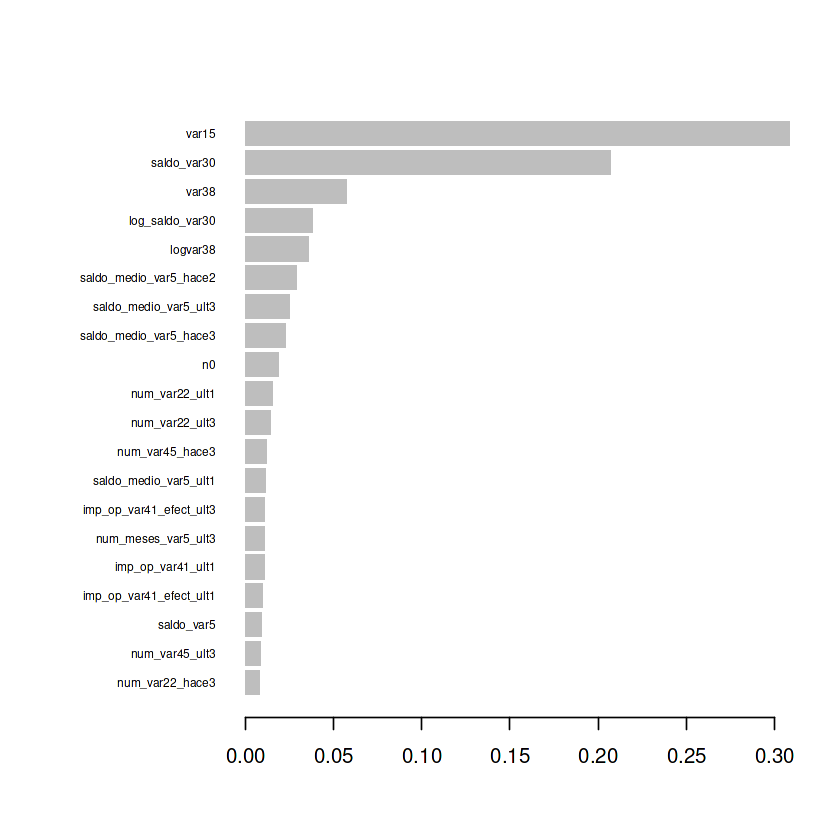

In [9]:
# 訓練模型
model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = xgbCV$best_iteration
)

preds <- predict(model, dtest)

# 可以印出哪些 features 對 xgboost 是重要的，取前 20 名
mat <- xgb.importance (feature_names = colnames(train), model = model)
xgb.plot.importance (importance_matrix = mat[1:20])


In [10]:
# 預測
predict_df <- data.frame(ID = test.id, TARGET = preds)

write.csv(
    predict_df,
    file = '/kaggle/working/submission_xgb_V5.csv',
    quote = FALSE,
    row.names = FALSE
)